# Sam Armstrong Assignment 5 CS545

In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import neuralnetworks as nn   # from notes 09
import copy

In [20]:
actions = (-1, 0, 1)   # Possible actions

def reinforcement(s, s1):
    return 0 if abs(s1[0]-s[2]) < 1 else -1
#     return -abs(s1[0] - s[2])

def initialState(goal=None):
    if goal is None:
        goal = np.random.randint(1,10)
    return np.array([10 * np.random.random_sample(), 0.0, goal])

def nextState(s, a):
    s = copy.copy(s)   # s[0] is position, s[1] is velocity. a is -1, 0 or 1
    deltaT = 0.1                           # Euler integration time step
    s[0] += deltaT * s[1]                  # Update position
    s[1] += deltaT * (2 * a - 0.2 * s[1])  # Update velocity. Includes friction
    if s[0] < 0:        # Bound next position. If at limits, set velocity to 0.
        s = [0,0, s[2]]
    elif s[0] > 10:
        s = [10,0,s[2]]
    return s

In [39]:
def epsilonGreedy(nnetQ, state, actions, epsilon):
    if np.random.uniform() < epsilon:
        # Random Move
        action = np.random.choice(actions)
    else:
        # Greedy Move
        Qs = [nnetQ.use(np.hstack((state, a)).reshape((1, -1))) for a in actions]
        ai = np.argmax(Qs)
        action = actions[ai]
    Q = nnetQ.use(np.hstack((state, action)).reshape((1, -1)))
    return action, Q

In [40]:
def makeSamples(nnet, initialStateF, nextStateF, reinforcementF,
                validActions, numSamples, epsilon, goal=None):

    X = np.zeros((numSamples, nnet.n_inputs))
    R = np.zeros((numSamples, 1))
    Qn = np.zeros((numSamples, 1))

    s = initialStateF(goal)
    s = nextStateF(s, 0)        # Update state, sn from s and a
    a, _ = epsilonGreedy(nnet, s, validActions, epsilon)

    # Collect data from numSamples steps
    for step in range(numSamples):
        sn = nextStateF(s, a)        # Update state, sn from s and a
        rn = reinforcementF(s, sn)   # Calculate resulting reinforcement
        an, qn = epsilonGreedy(nnet, sn, validActions, epsilon) # Forward pass for time t+1
        X[step, :] = np.hstack((s, a))
        R[step, 0] = rn
        Qn[step, 0] = qn
        # Advance one time step
        s, a = sn, an

    return (X, R, Qn)

In [49]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def plotStatus(net, trial, epsilonTrace, rtrace, goal=5):
    plt.subplot(7, 3, 1)
    plt.plot(epsilonTrace[:trial + 1])
    plt.ylabel('Random Action Probability ($\epsilon$)')
    plt.ylim(0, 1)
    plt.subplot(7, 3, 2)
    plt.plot(X[:, 0])
    plt.plot([0, X.shape[0]], [goal, goal], '--', alpha=0.5, lw=5)
    plt.ylabel('$x$')
    plt.ylim(-1, 11)
    qs = net.use(np.array([[s, 0, goal, a] for a in actions for s in range(11)]))
    plt.subplot(7, 3, 3)
    acts = ['L', '0', 'R']
    actsiByState = np.argmax(qs.reshape((len(actions), -1)), axis=0)
    for i in range(11):
        plt.text(i, 0, acts[actsiByState[i]])
        plt.xlim(-1, 11)
        plt.ylim(-1, 1)
    plt.text(2, 0.2, 'Policy for Zero Velocity')
    plt.axis('off')
    plt.subplot(7, 3, 4)
    plt.plot(rtrace[:trial + 1], alpha=0.5)
    binSize = 20
    if trial + 1 > binSize:
        # Calculate mean of every bin of binSize reinforcement values
        smoothed = np.mean(rtrace[:int(trial / binSize) * binSize].reshape((int(trial / binSize), binSize)),
                           axis=1)
        plt.plot(np.arange(1, 1 + int(trial / binSize)) * binSize, smoothed)
    plt.ylabel('Mean reinforcement')
    plt.subplot(7, 3, 5)
    plt.plot(X[:, 0], X[:, 1])
    plt.plot(X[0, 0], X[0, 1], 'o')
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.fill_between([goal-1, goal+1], [-5, -5], [5, 5], color='red', alpha=0.3)
    plt.xlim(-1, 11)
    plt.ylim(-5, 5)
    plt.subplot(7, 3, 6)
    net.draw(['$x$', '$\dot{x}$', '$a$'], ['Q'])
    
    plt.subplot(7, 3, 7)
    n = 20
    positions = np.linspace(0, 10, n)
    velocities =  np.linspace(-5, 5, n)
    xs, ys = np.meshgrid(positions, velocities)
    xsflat = xs.flat
    ysflat = ys.flat
    qs = net.use(np.array([[xsflat[i], ysflat[i], goal, a] for a in actions for i in range(len(xsflat))]))
    qs = qs.reshape((len(actions), -1)).T
    qsmax = np.max(qs, axis=1).reshape(xs.shape)
    cs = plt.contourf(xs, ys, qsmax)
    plt.colorbar(cs)
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.title('Max Q')
    plt.subplot(7, 3, 8)
    acts = np.array(actions)[np.argmax(qs, axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs, ys, acts, [-2, -0.5, 0.5, 2])
    plt.colorbar(cs)
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.title('Actions')
    
    s = plt.subplot(7, 3, 10)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(), rect=rect)
    ax.plot_surface(xs, ys, qsmax, cstride=1, rstride=1, cmap=cm.jet, linewidth=0)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\dot{x}$')
    plt.title('Max Q')
    
    s = plt.subplot(7, 3, 11)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(), rect=rect)
    ax.plot_surface(xs, ys, acts, cstride=1, rstride=1, cmap=cm.jet, linewidth=0)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\dot{x}$')
    plt.title('Action')
    
    plt.tight_layout()

In [50]:
def testIt(Qnet, nTrials, nStepsPerTrial):
    xs = np.linspace(0, 10, nTrials)
    for r in range(1, 10):
        plt.subplot(7, 3, 11 + r)
        for x in xs:
            s = [x, 0, r] # 0 velocity
            xtrace = np.zeros((nStepsPerTrial, 3))
            for step in range(nStepsPerTrial):
                a,_ = epsilonGreedy(Qnet, s, actions, 0.0) # epsilon = 0
                s = nextState(s, a)
                xtrace[step, :] = s
            plt.plot(xtrace[:, 0], xtrace[:, 1])
            plt.xlim(-1, 11)
            plt.ylim(-5, 5)
            plt.plot([r, r], [-5, 5], '--', alpha=0.5, lw=5)
            plt.ylabel('$\dot{x}$')
            plt.xlabel('$x$')
            plt.title('State Trajectories With Goal='+str(r))

In [51]:
def setupStandardization(net, Xmeans, Xstds, Tmeans, Tstds):
    net.Xmeans = Xmeans
    net.XstdsFixed = Xstds
    net.Xconstant = [False] * len(Xmeans)
    net.TstdsFixed = net.Tstds = Tstds
    net.Tmeans = Tmeans
    net.Tconstant = [False] * len(Tstds)

In [80]:
def test(goal=None, gamma=0.8, nTrials=500, nStepsPerTrial=1000, nSCGIterations=10, finalEpsilon=0.01, nh = [20, 20, 20]):   
    from IPython.display import display, clear_output
    fig = plt.figure(figsize=(10 ,20))

    epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
    print('epsilonDecay is',epsilonDecay)
    nnetQ = nn.NeuralNetwork(4, nh, 1)
    # Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
    setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

    epsilon = 1         # initial epsilon value
    epsilonTrace = np.zeros(nTrials)
    rtrace = np.zeros(nTrials)
    for trial in range(nTrials):
        # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
        
        X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
        nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

        # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
        # Rest is for plotting
        epsilonTrace[trial] = epsilon
        epsilon *= epsilonDecay
        rtrace[trial] = np.mean(R)
        if True and (trial + 1 == nTrials or trial % (nTrials / 10) == 0):
            fig.clf()
            if(goal is None):
                plotStatus(nnetQ, trial, epsilonTrace, rtrace)
            else:
                plotStatus(nnetQ, trial, epsilonTrace, rtrace, goal)
            testIt(nnetQ, 10, 500)
            clear_output(wait=True)
            display(fig)

    clear_output(wait=True)

## Goal = 1

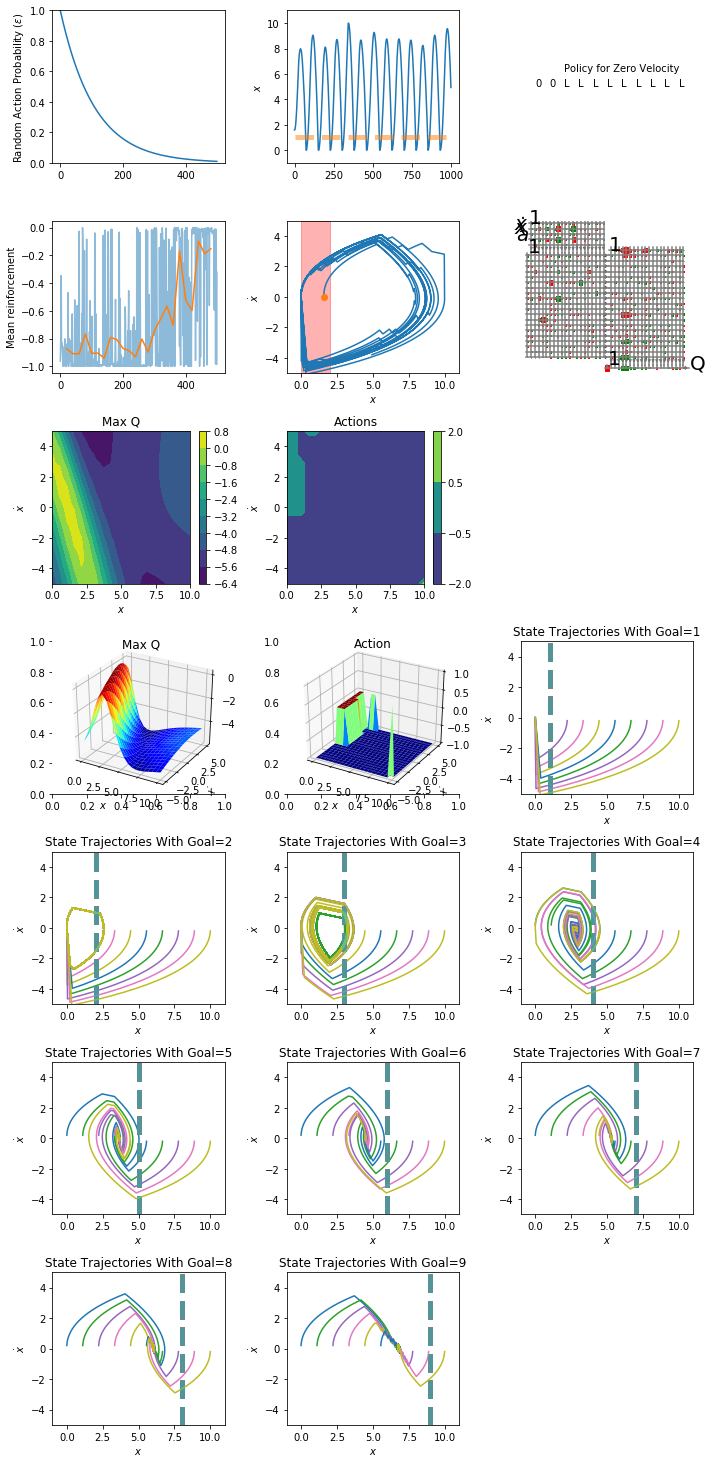

In [81]:
test(goal=1)

## Goal = 5

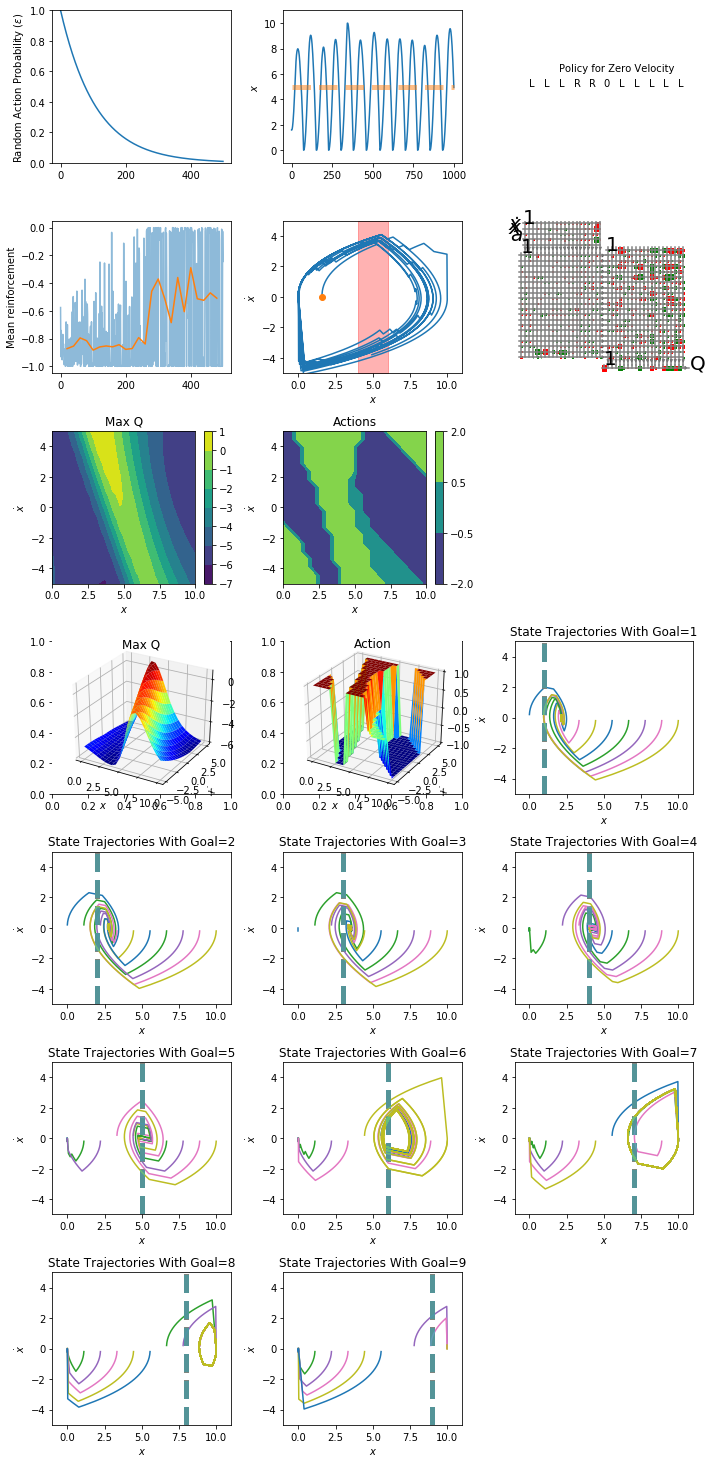

In [82]:
test(goal=5)

## Goal = 9

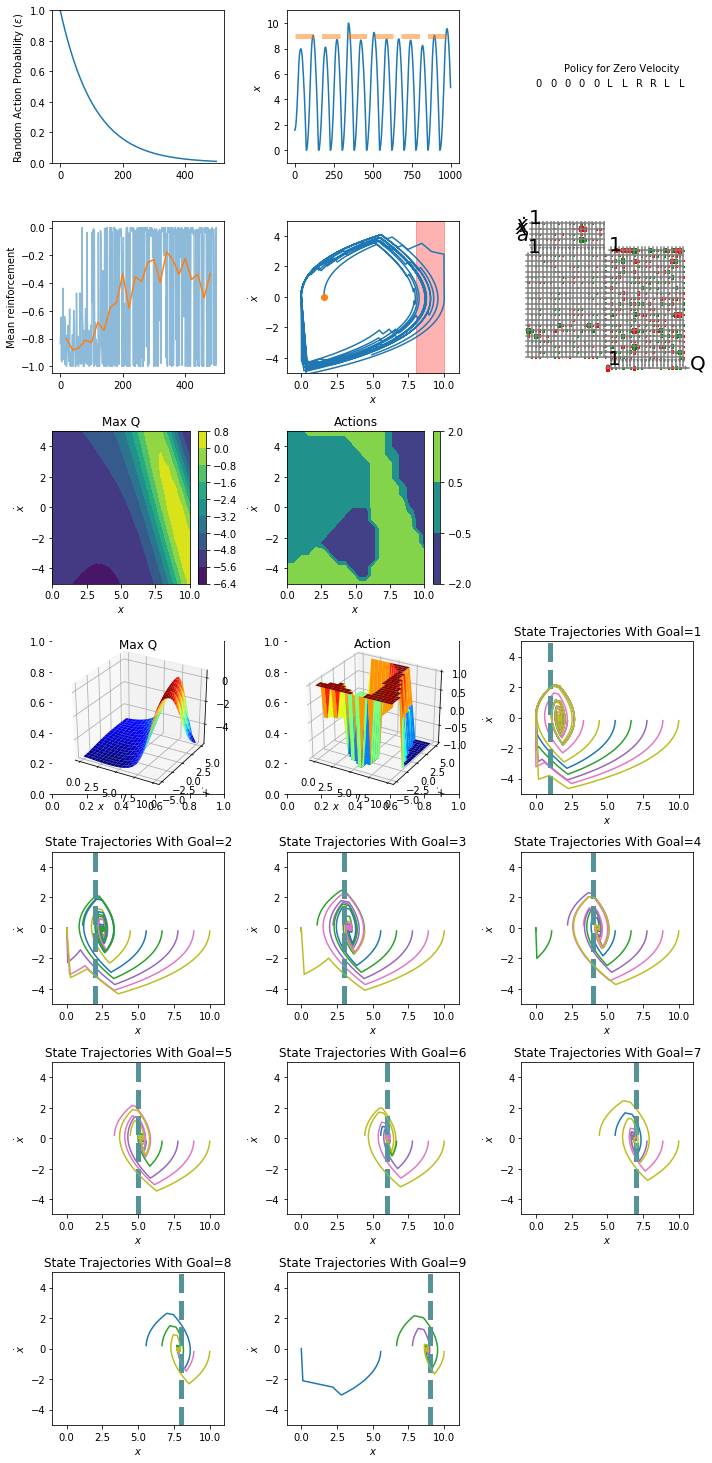

In [83]:
test(goal=9)

## Experiment Number of Trials

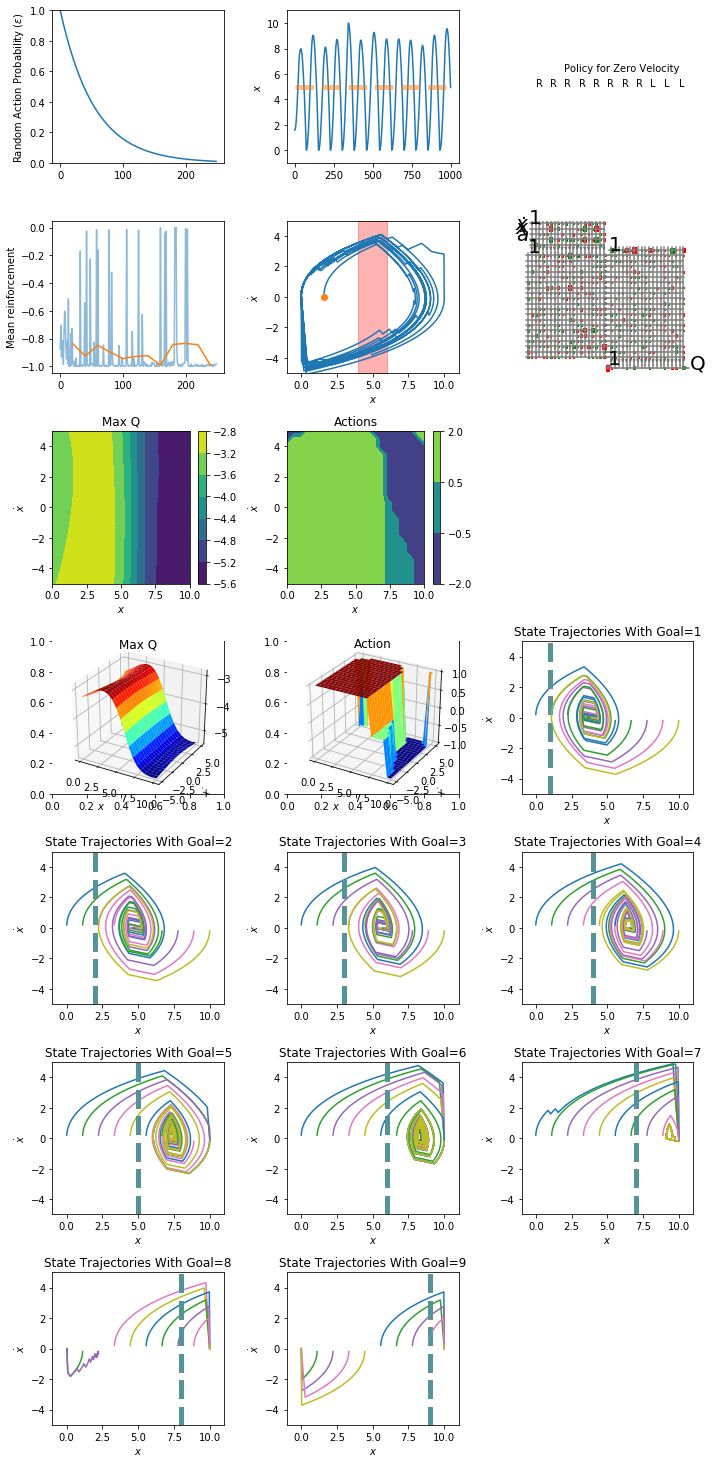

In [84]:
test(nTrials=250) 

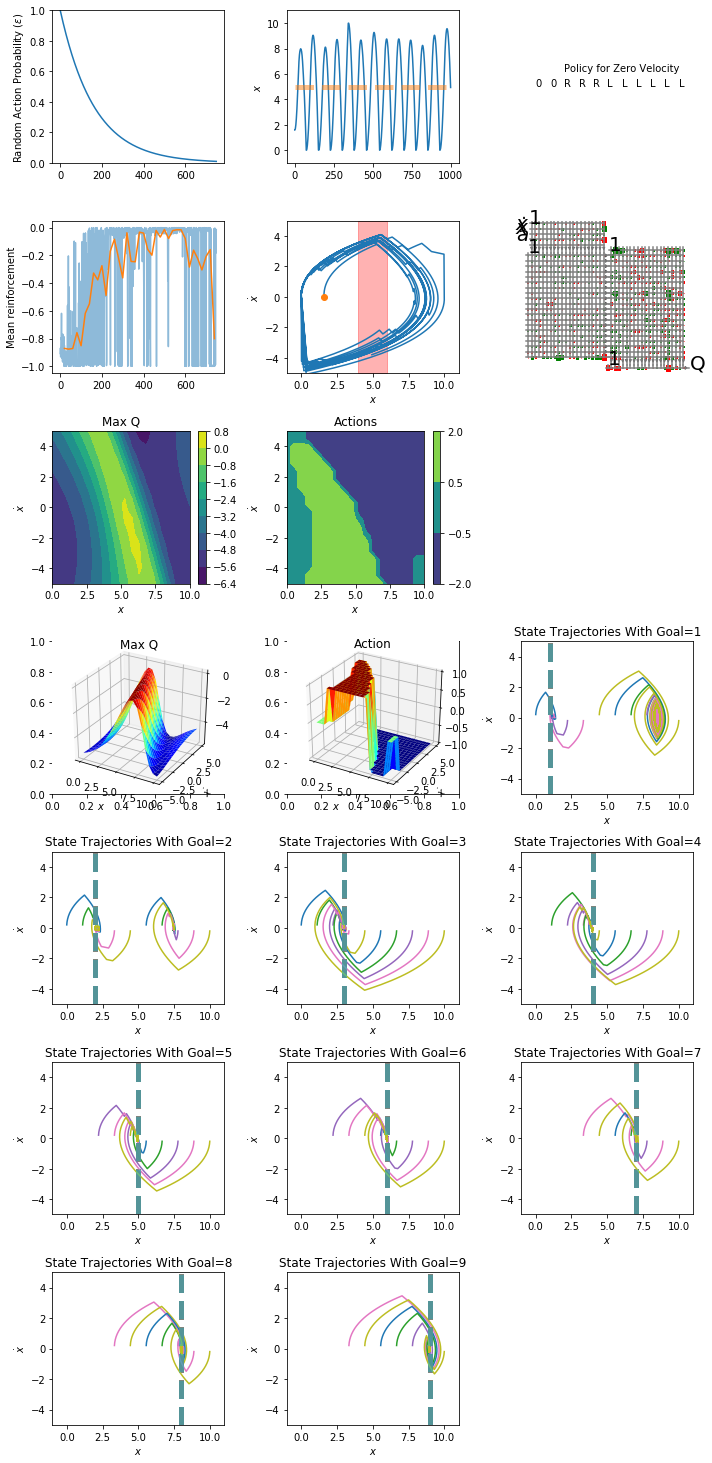

In [85]:
test(nTrials=750) 

## Experiment Number of Steps per Trial

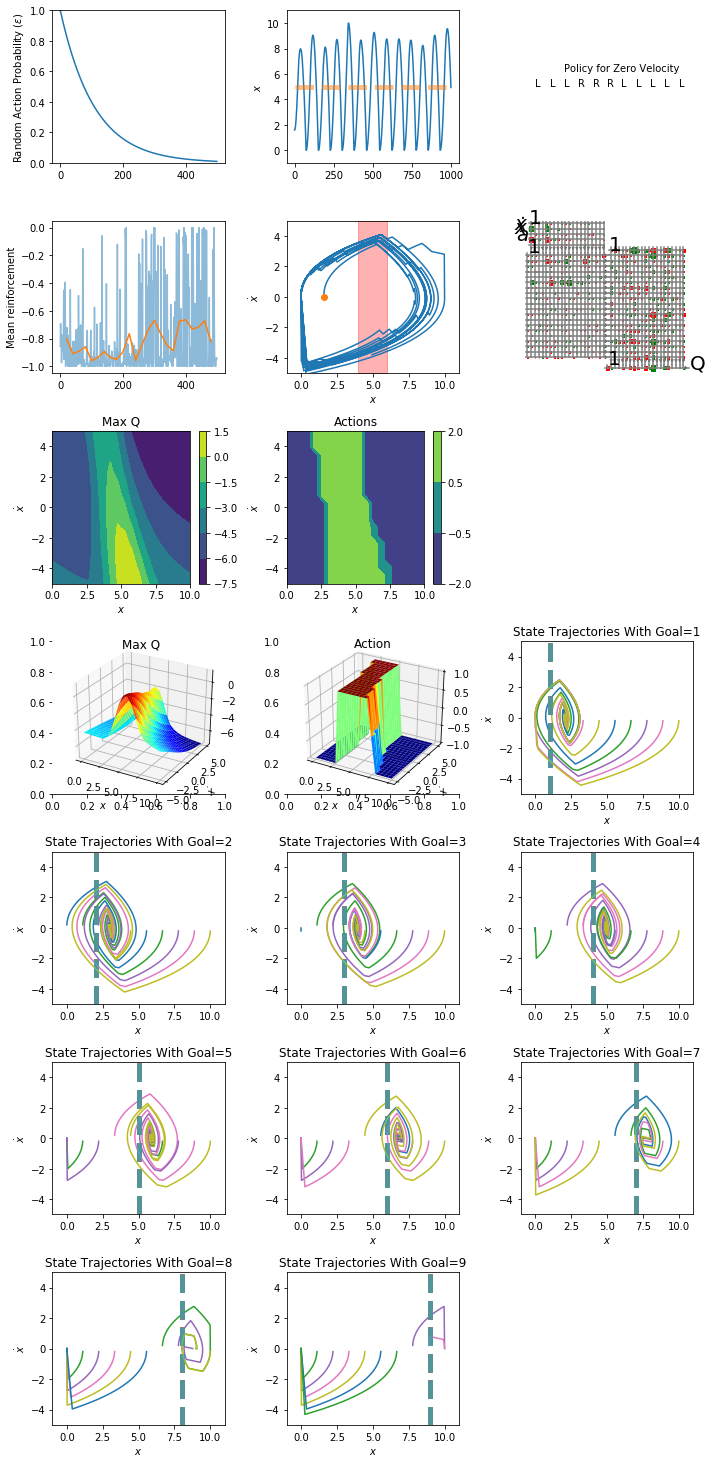

In [86]:
test(nStepsPerTrial=500)

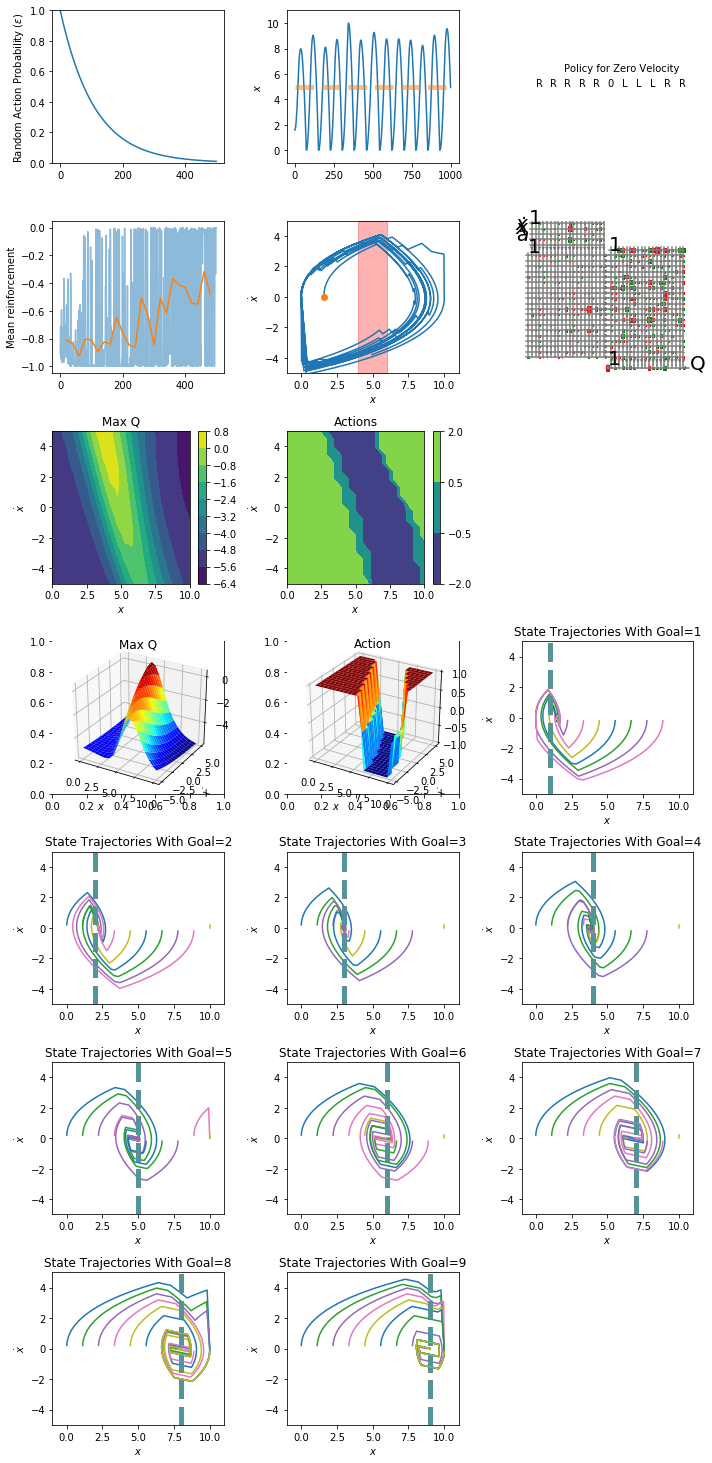

In [87]:
test(nStepsPerTrial=1500)

## Experiment Number of SCG Iterations in Each Train Call

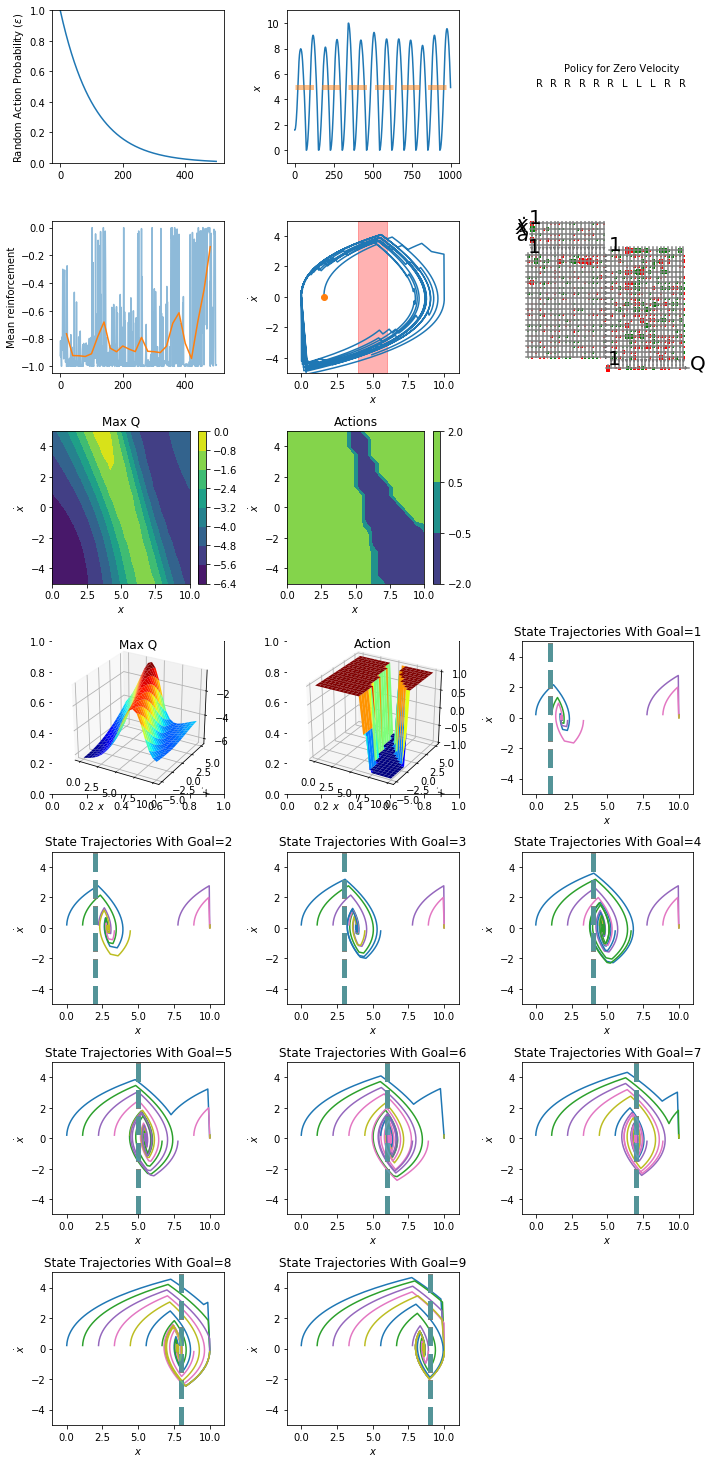

In [88]:
test(nSCGIterations=5) 

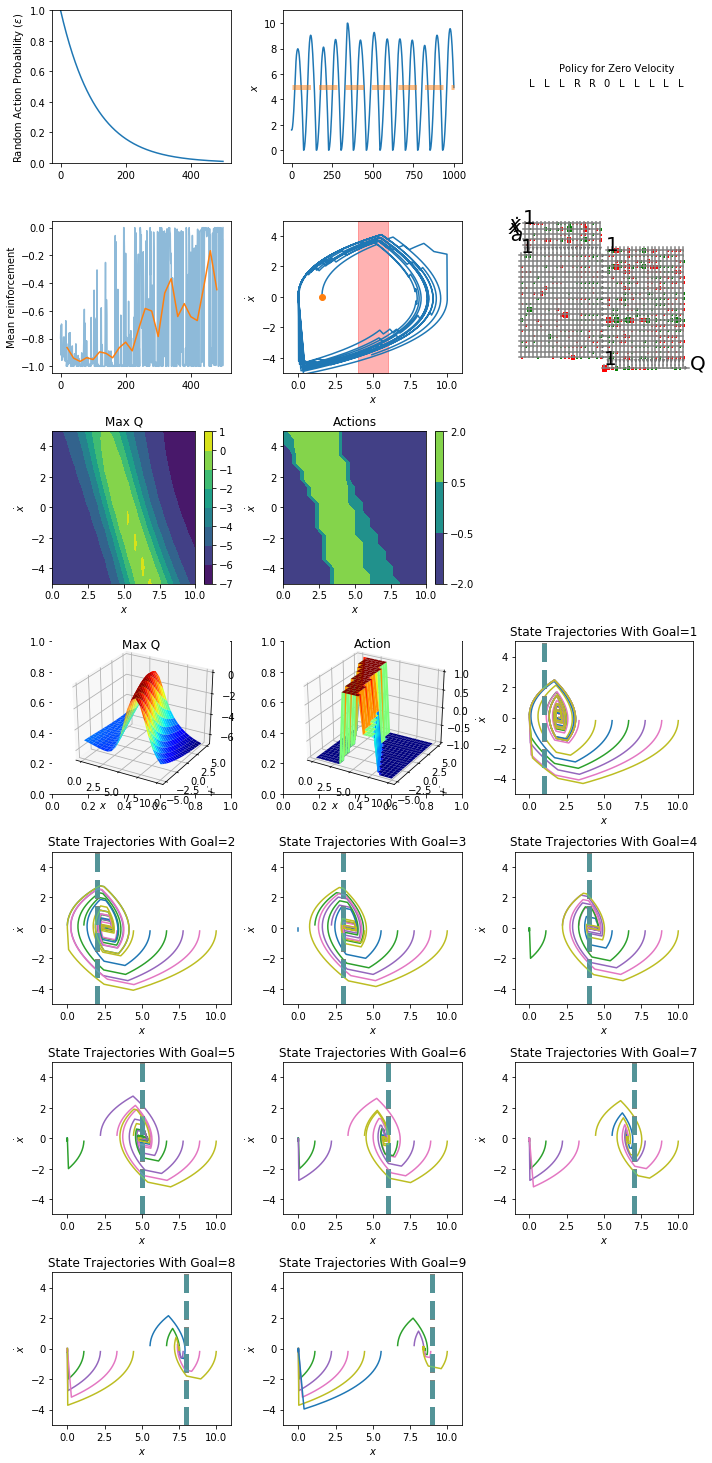

In [89]:
test(nSCGIterations=15) 

## Experiment Number of Hidden Units

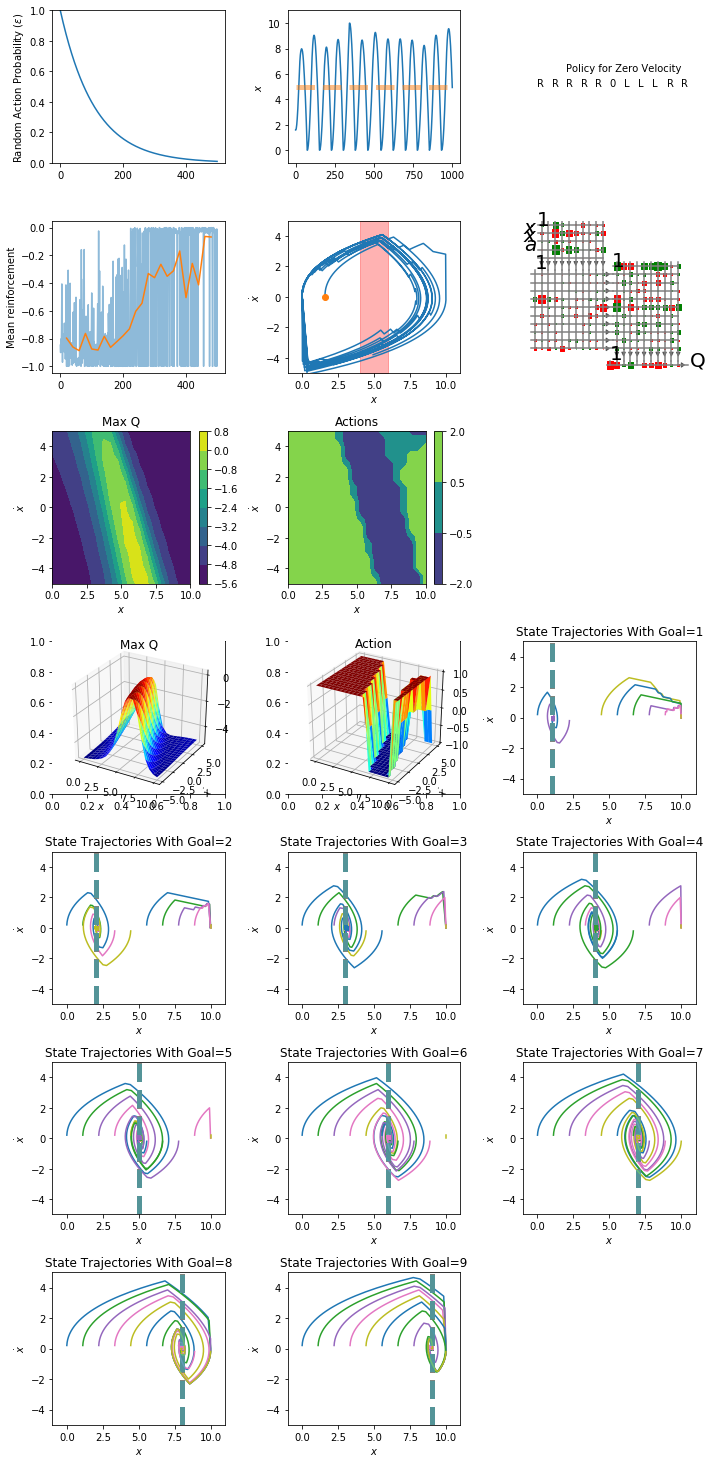

In [90]:
test(nh = [10, 10, 10], nSCGIterations=5)

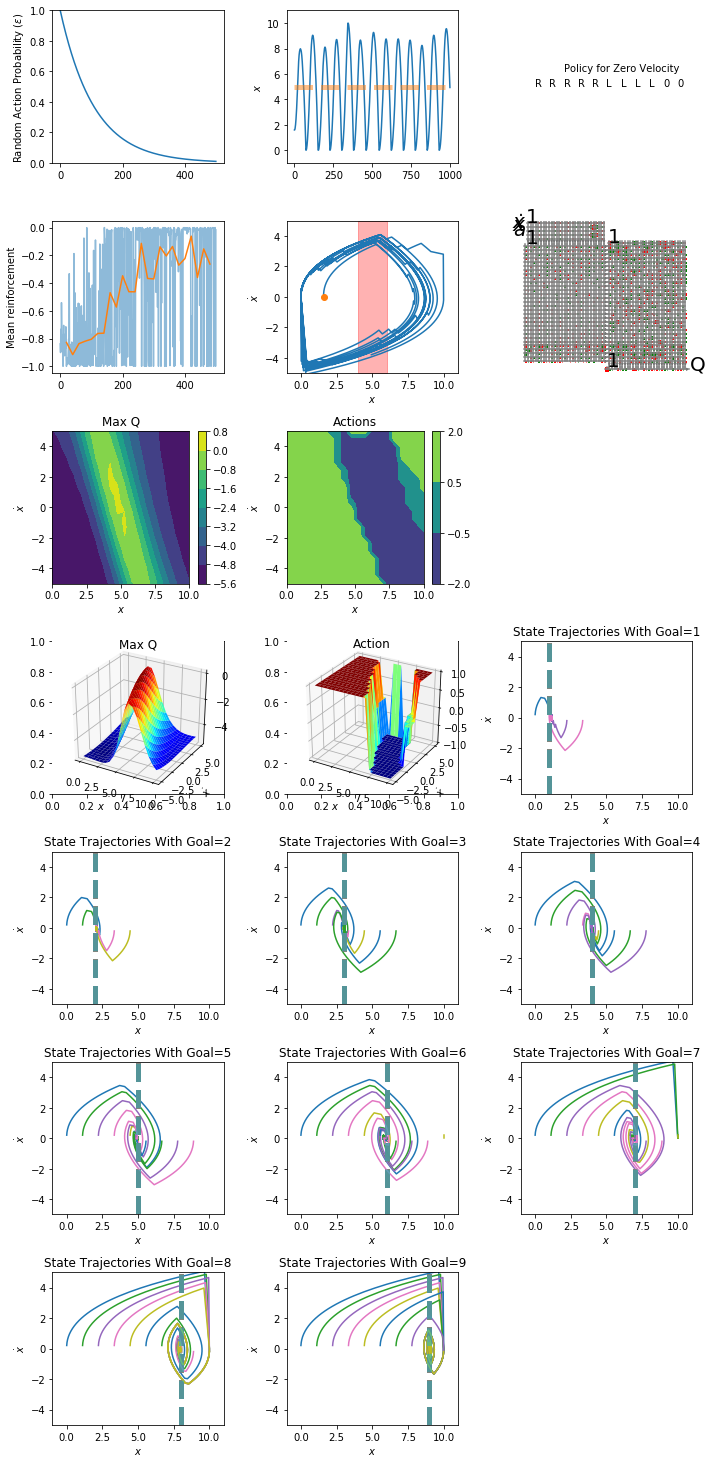

In [91]:
test(nh = [30, 30, 30], nSCGIterations=15)

## Experiment Final Epsilon

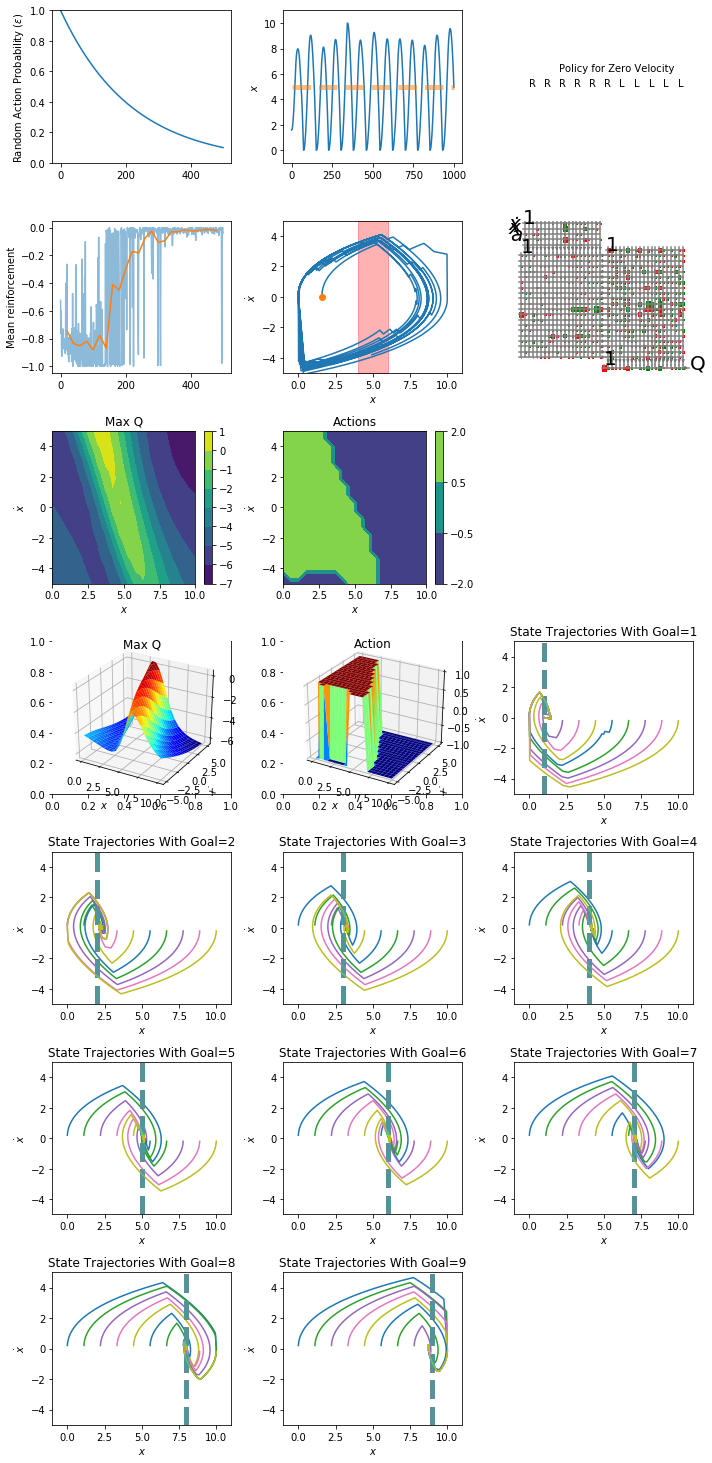

In [92]:
test(finalEpsilon=0.1)

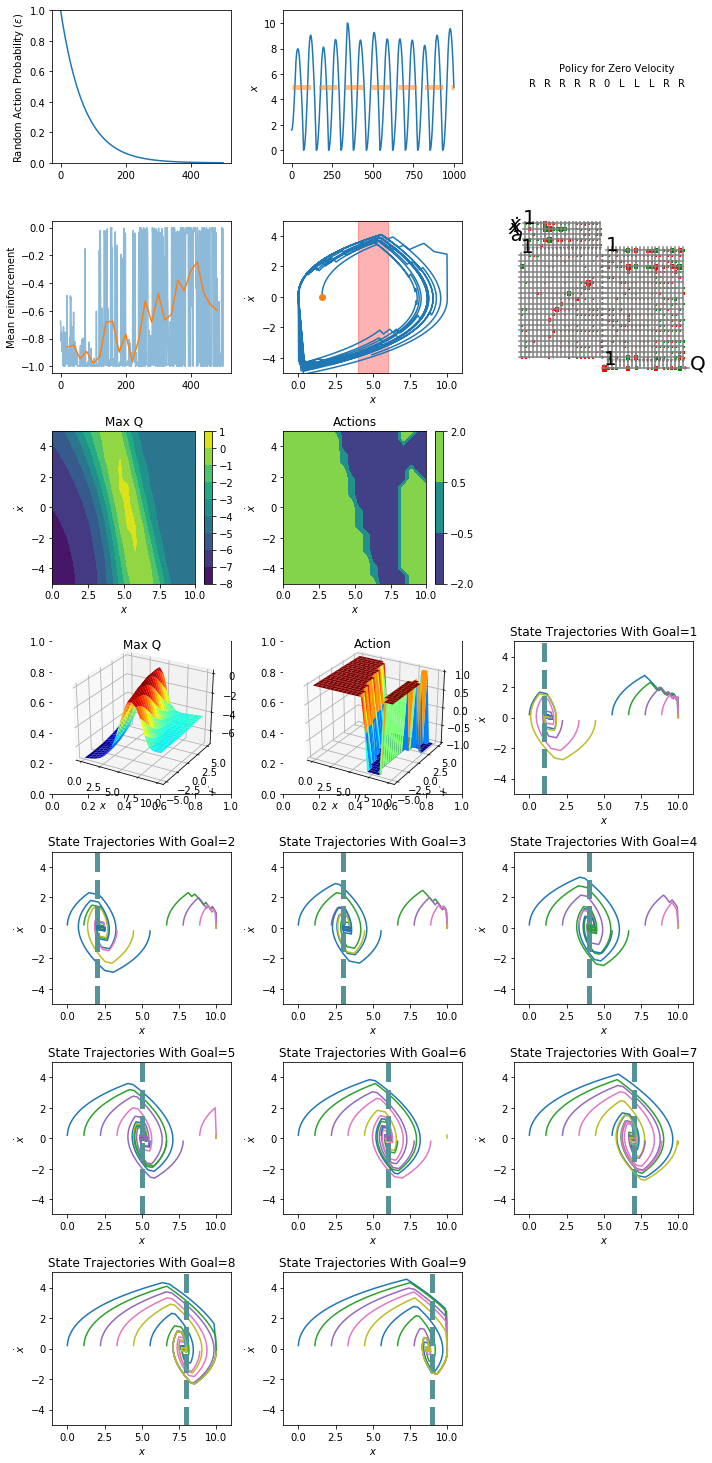

In [93]:
test(finalEpsilon=0.001)

## Experiment Gamma

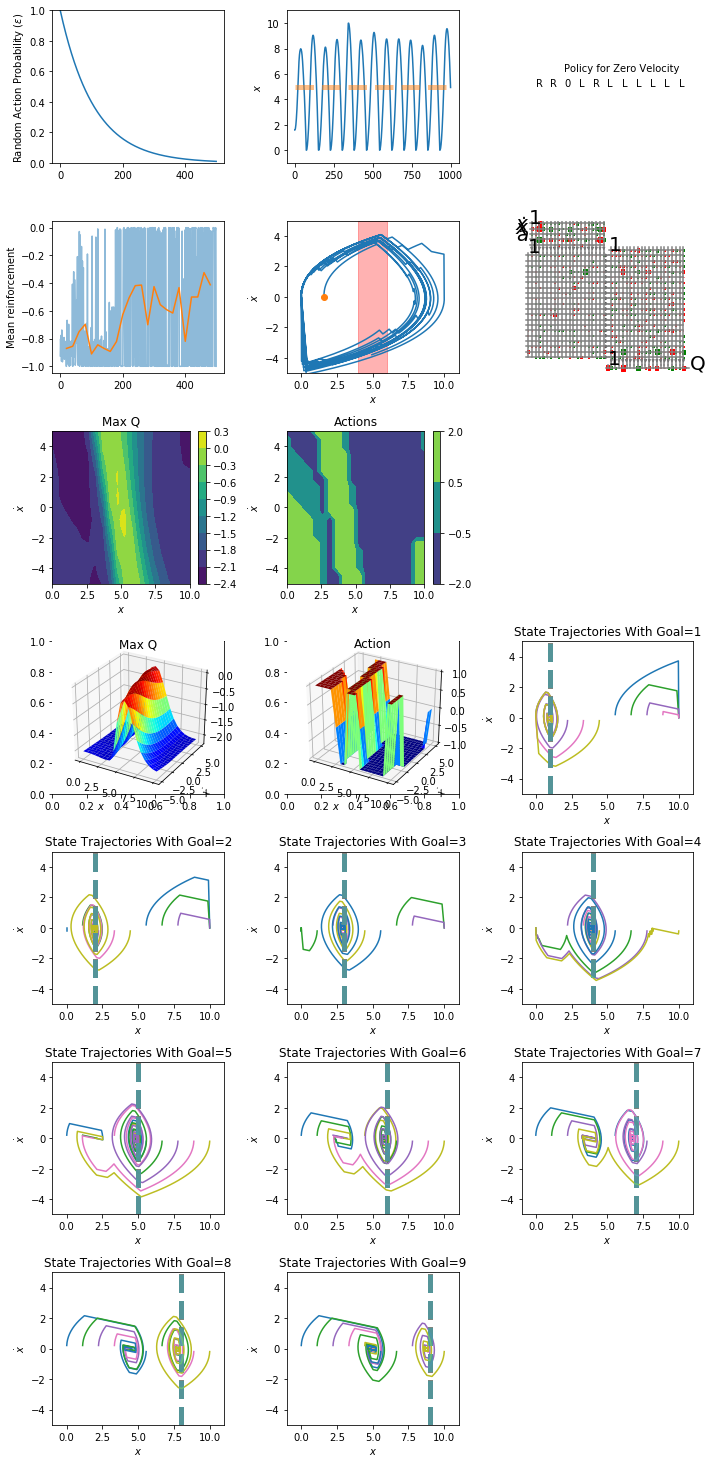

In [94]:
test(gamma=0.5)

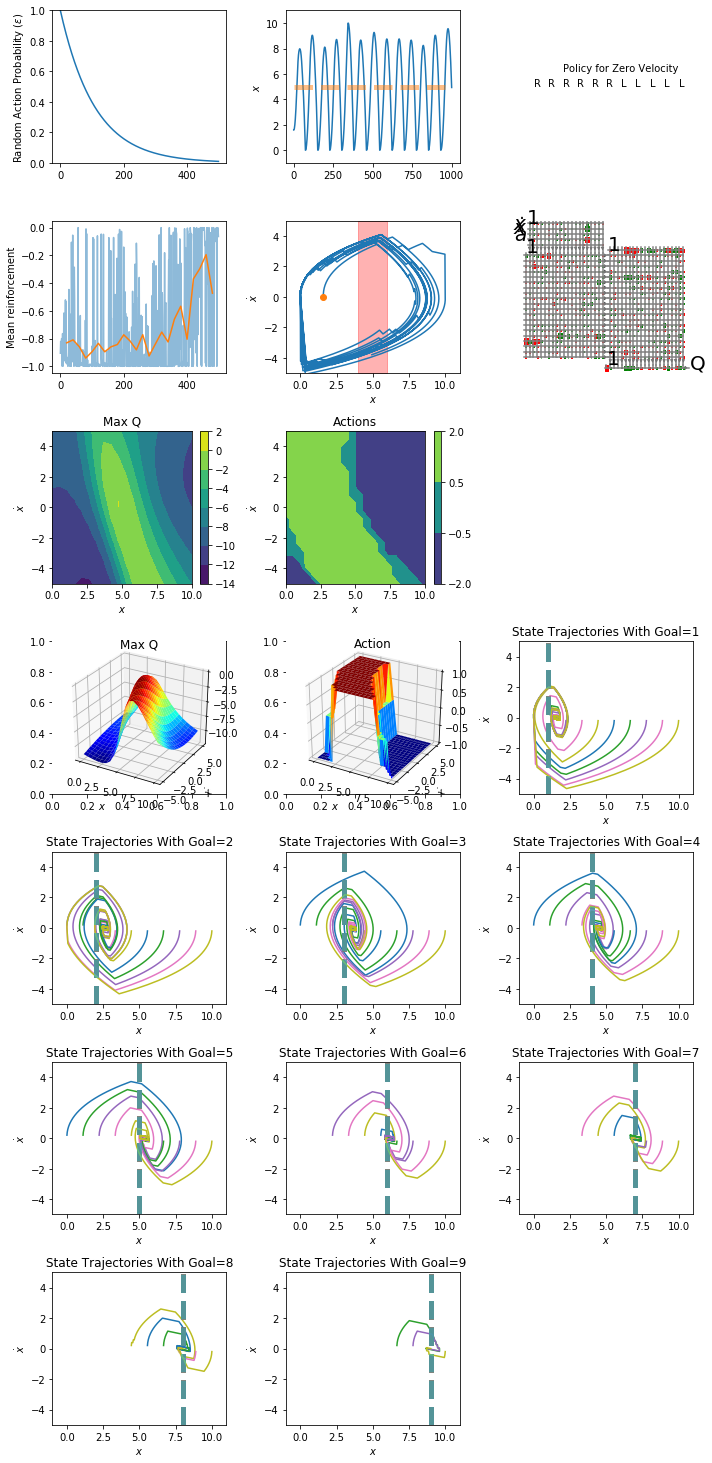

In [95]:
test(gamma=0.9)

## Discussion

Increasing the number of trials seems to increase the marble's ability to stay in the goal state which is evident in the projections of the model with more trials where the marble circles around the goal state less. Increasing the number of steps per trial seems to effect the marbles ability to get to and stay in the goal state which you can see in the trajectories with the lower steps where the marble is not able to get into some of the goal states at all. Increasing the number of SCG iterations seems to decrease the range of start states that can get to a goal state. Intuitively this makes sense because the model is likely being overtrained and is therefore less versatile in the range of start states and range of goal states (1-9). Increasing the number of hidden layers (also increasing the SCG training iterations to compensate for the increase in layers) seems to increase the marbles ability to get and stay in the goal state which can be seen in the trajectories. Decreasing the final epsilon has a similar effect as increasing the SCG iterations and seems to decrease the range of starting positions that can get to the goal state (likely caused by overfitting). Decreasing gamma seems to decrease the marbles ability to get to and stay in the goal state with the higher gamma model getting to the goal state very quickly/efficiently. Overall it seems that a more complex model performs better, but is susceptible to overfitting. 

In [96]:
# !rm A5grader.zip
# !rm A5grader.py
# !wget http://www.cs.colostate.edu/~anderson/cs545/notebooks/A5grader.zip
# !unzip A5grader.zip
%run -i A5grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Armstrong-A5.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

######################################################################
Testing

s = initialState(6.6)


--- 20/20 points. initialState correctly returns goal of 6.6 as third component.

######################################################################
Testing

r = reinforcement(np.array([2.8, 2, 3]), np.array([3.6, 1, 3]))


--- 20/20 points. reinforcement correctly returns 0.

######################################################################
Testing

r = reinforcement(np.array([7., 2., 3.]), np.array([8., 1., 3.]))


--- 20/20 points. reinforcement correctly returns -1.

######################################################################
Testing

s_next = nextState(np.array([1.0, 0.0, 7.0]), 1.0)



--- 10/10 points. nextState correc

<Figure size 432x288 with 0 Axes>